In [20]:
from subprocess import call
import copy
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import csv
%matplotlib notebook

In [2]:
PTS_P_FILE = "pts_p_file.csv"
PTS_Q_FILE = "pts_q_file.csv"
PERF_FILE = "perf_file.csv"
PROGRAM_PATH = "./main"

In [3]:
# Random point generation in square region
def generate_rand_pts_sq(x, y, r, num):
    ret_list = []
    for i in range(num):
        ret_list.append((2 * r * np.random.random_sample() + x - r,
                     2 * r * np.random.random_sample() + y - r))
    return ret_list

In [4]:
# Random point generation in polygon
def generate_rand_pts_poly(x, y, r, num, poly):
    # generate polygon
    thetas = np.linspace(0, 2 * np.pi, poly+1)[:-1]
    xs = np.cos(thetas) * r + x
    ys = np.sin(thetas) * r + y
    polygon = Polygon(list(zip(xs, ys)))
    min_x, min_y, max_x, max_y = polygon.bounds
    ret_list = []
    i = 0
    while i < num:
        rx = np.random.uniform(min_x, max_x)
        ry = np.random.uniform(min_y, max_y)
        p = Point(rx, ry)
        if p.within(polygon):
            ret_list.append((rx, ry))
            i += 1
    return ret_list

In [5]:
# Random point generation in disk region (discard method)
def generate_rand_pts_disk(x, y, r, num):
    ret_list = []
    i = 0
    while i < num:
        pnt = (
            (2 * r * np.random.random_sample() + x - r),
            (2 * r * np.random.random_sample() + y - r)
        )
        if (pnt[0] - x)**2 + (pnt[1] - y)**2 <= r**2:
            ret_list.append(pnt)
            i += 1
    return ret_list

In [6]:
# Random point generation in disk region (discard method)
def generate_rand_pts_circ(x, y, r, num):
    ret_list = []
    for i in range(num):
        theta = 2 * np.pi * np.random.random_sample()
        pnt = (
            r * np.cos(theta),
            r * np.sin(theta)
        )
        ret_list.append(pnt)
    return ret_list

In [7]:
def write_pts_list(pts_list, PTS_FILE):
    with open(PTS_FILE, "w") as pts_file:
        for pnt in pts_list:
            pts_file.write(str(pnt[0]) + "," + str(pnt[1]) + "\n")

In [8]:
def read_pts_list(PTS_FILE):
    pts_list = []
    with open(PTS_FILE) as pts_file:
        csv_reader = csv.reader(pts_file, delimiter=",")
        for row in csv_reader:
            pts_list.append(tuple(map(float, row)))
        return pts_list

In [9]:
def move_pnt(pnt, delta_x, delta_y):
    new_pnt = (pnt[0] + delta_x, pnt[1] + delta_y)
    return new_pnt

In [10]:
def replace_pnt(pts_list, pnt, new_pnt): # returns new list with pnt replaced with new_pnt
    assert pnt in pts_list
    ret_list = copy.deepcopy(pts_list)
    ret_list.remove(pnt)
    ret_list.append(new_pnt)
    return ret_list

In [11]:
def plot_pts_list(pts_list):
    plt.scatter(np.array(pts_list)[:,0], np.array(pts_list)[:,1], s=4, c=[[0,0,0]])
    plt.grid(True)
    plt.xlabel("x coordinate")
    plt.ylabel("y coordinate")
    plt.axes().set_aspect('equal')
    plt.show()

In [12]:
def run_average(num_iter, samp_func, xp, yp, rp, np, xq, yq, rq, nq, poly=4):
    perf_dict = dict()
    for i in range(num_iter):
        if samp_func is generate_rand_pts_poly:
            write_pts_list(samp_func(xp, yp, rp, np, poly), PTS_P_FILE)
            write_pts_list(samp_func(xq, yq, rq, nq, poly), PTS_Q_FILE)
        else:
            write_pts_list(samp_func(xp, yp, rp, np), PTS_P_FILE)
            write_pts_list(samp_func(xq, yq, rq, nq), PTS_Q_FILE)
        call(PROGRAM_PATH)
        with open(PERF_FILE) as perf_file:
            csv_reader = csv.reader(perf_file, delimiter=",")
            for row in csv_reader:
                if (row[0] in perf_dict):
                    perf_dict[row[0]] += float(row[1])
                else:
                    perf_dict[row[0]] = float(row[1])
    for i in perf_dict.keys():
        perf_dict[i] /= num_iter
    return perf_dict

In [13]:
sq_res = [run_average(1000, generate_rand_pts_sq, *(-1000, 0, 500, 2**i), *(1000, 0, 500, 2**i))['tang'] for i in range(10)]

In [14]:
circ_res = [run_average(1000, generate_rand_pts_circ, *(-1000, 0, 500, 2**i), *(1000, 0, 500, 2**i))['tang'] for i in range(10)]

In [15]:
disk_res = [run_average(1000, generate_rand_pts_disk, *(-1000, 0, 500, 2**i), *(1000, 0, 500, 2**i))['tang'] for i in range(10)]

In [16]:
poly_tri_res = [run_average(1000, generate_rand_pts_poly, *(-1000, 0, 500, 2**i), *(1000, 0, 500, 2**i), poly=3)['tang'] for i in range(10)]

In [17]:
poly_sq_res = [run_average(1000, generate_rand_pts_poly, *(-1000, 0, 500, 2**i), *(1000, 0, 500, 2**i), poly=4)['tang'] for i in range(10)]

In [18]:
poly_pent_res = [run_average(1000, generate_rand_pts_poly, *(-1000, 0, 500, 2**i), *(1000, 0, 500, 2**i), poly=5)['tang'] for i in range(10)]

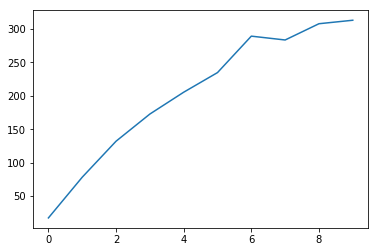

In [16]:
plt.plot(sq_res)

Text(0, 0.5, 'Running time (ns)')

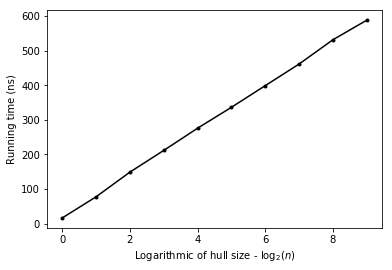

In [21]:
plt.plot(circ_res, c=(0,0,0), marker=".")
# x = np.linspace(0,9,100)
# y = 64.27276471 * x + 14.93888971
# plt.plot(x, y, '--', c=(0,0,0), linewidth=1)
plt.xlabel("Logarithmic of hull size - $\log_2(n)$")
plt.ylabel("Running time (ns)")
# plt.savefig("../docs/report/images/tangent_computation_performance.png")

In [24]:
disk_res

[16.371,
 78.192,
 127.893,
 167.572,
 197.67,
 223.183,
 257.281,
 279.767,
 309.755,
 328.822]

<IPython.core.display.Javascript object>


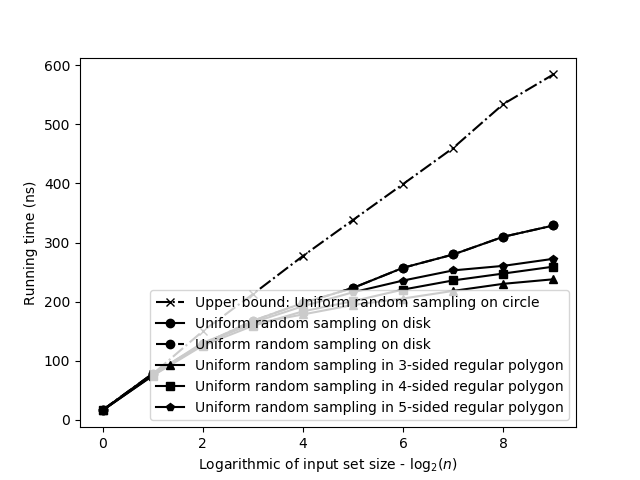

In [21]:
plt.plot(circ_res, "-.", c=(0,0,0), marker="x", label="Upper bound: Uniform random sampling on circle")
plt.plot(disk_res, c=(0,0,0), marker="o", label="Uniform random sampling on disk")
# x = np.linspace(0,9,100)
# y = 64.27276471 * x + 14.93888971
# plt.plot(x, y, '--', c=(0,0,0), linewidth=1)
plt.xlabel("Logarithmic of input set size - $\log_2(n)$")
plt.ylabel("Running time (ns)")
plt.legend(loc='upper left')
plt.savefig("../docs/report/images/uniform_disk_input.png")

<IPython.core.display.Javascript object>


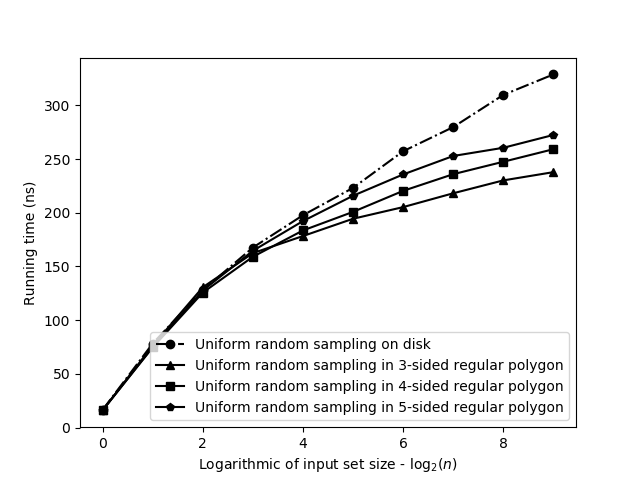

In [23]:
plt.plot(disk_res, "-.", c=(0,0,0), marker="o", label="Uniform random sampling on disk")
plt.plot(poly_tri_res, c=(0,0,0), marker="^", label="Uniform random sampling in 3-sided regular polygon")
plt.plot(poly_sq_res, c=(0,0,0), marker="s", label="Uniform random sampling in 4-sided regular polygon")
plt.plot(poly_pent_res, c=(0,0,0), marker="p", label="Uniform random sampling in 5-sided regular polygon")
# x = np.linspace(0,9,100)
# y = 64.27276471 * x + 14.93888971
# plt.plot(x, y, '--', c=(0,0,0), linewidth=1)
plt.xlabel("Logarithmic of input set size - $\log_2(n)$")
plt.ylabel("Running time (ns)")
plt.legend(loc='lower right')
plt.savefig("../docs/report/images/uniform_polygon_input.png")

In [27]:
poly_pent_res

[16.088,
 75.002,
 127.57,
 164.573,
 192.23,
 215.828,
 235.682,
 252.868,
 260.496,
 272.446]

In [18]:
plt.plot(disk_), c=(0,0,0), marker=".")
x = np.linspace(0,15,100)
y = 64.27276471 * x + 14.93888971
plt.plot(x, y, '--', c=(0,0,0), linewidth=1)
plt.xlabel("Logarithmic of hull size - $\log_2(n)$")
plt.ylabel("Running time (ns)")
# plt.savefig("../docs/report/images/tangent_computation_performance.png")

[16.702,
 77.789,
 149.076,
 211.698,
 275.846,
 336.267,
 398.804,
 461.214,
 531.326,
 587.875]

In [49]:
np.polyfit(range(16), circ_res,1)

array([64.27276471, 14.93888971])

In [44]:
[2**i for i in range(16)]

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

In [57]:
plt.plot(disk_res)

In [25]:
sq_res

[16.001,
 75.666,
 129.693,
 174.34,
 202.038,
 228.439,
 251.075,
 277.357,
 295.277,
 312.522,
 324.943,
 332.613,
 345.472,
 358.002,
 365.963,
 373.815]

In [26]:
circ_res

[16.191,
 77.376,
 150.99,
 210.307,
 275.398,
 335.235,
 402.821,
 465.305,
 524.074,
 589.302,
 645.533,
 713.073,
 778.048,
 853.159,
 918.426,
 996.516]

In [19]:
disk_res

[15.865,
 77.384,
 144.117,
 186.961,
 222.182,
 251.854,
 276.92,
 302.073,
 323.723,
 340.27,
 366.577,
 393.628,
 404.821,
 436.493,
 453.361,
 465.007]